# Úvod

V této práci jsem realizoval implementaci knihovny Gensim a technologie vektorové reprezentace sémantiky slov (model word2vec) pro sémantické vyhledávání v korpusu české poezie od projektu VersoTym.

Na začátku je sekce "Ukázka" demonstrující realizaci algoritmu. V následujících sekcích popisuji kroky přípravy daného programu, optimizační návrhy a další zajímavé příklady vyhledávání.

## Ukázka

Aby všechno správně fungovalo, je třeba zkopírovat na svůj Google Disk složku Word2Vec dostupnou z odkazu:
https://drive.google.com/drive/folders/16NvmmxnqfISLNCFVD142u9fm5hEDfPbW?usp=sharing

Složka obsahuje vektorový model češtiny a databázi českých básní. Soubory jsou poměrně velké (dohromady cca 10Gb), proto se s nimi snáze pracuje v Colabu přímo z Google Disku bez nutnosti je stahovat na svůj počítač.

In [ ]:
# vsechny potrebne knihovny 

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

!pip install gensim
from gensim.models import KeyedVectors
from gensim import models
from gensim.models import Word2Vec

!pip install zarr
import zarr

import numpy as np

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 64.1 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=9dbb644af8dd60b0a700eb45b92971cd5a223b5a252450a70d28f6f197e88754
  Stored in directory: /root/.cache/pip/wheels/a3/d7/75/19cd0d2a893cad4bb0b2b16dd572ad2916d19c0d5ee9612511
Successfully built asciitree


### Kód

Tuto buňku stačí jenom spustit, aby vyhledávání fungovalo. Podrobný popis toho, jak funguje každá funkce jsem uvedl v sekci "Příprava práce".

In [ ]:
print('loading model...')
model = KeyedVectors.load("drive/MyDrive/Word2Vec/cswiki-latest-pages-articles.word2vec", mmap='r')

print('loading database...')
store = zarr.DBMStore('drive/MyDrive/Word2Vec/database')
database = zarr.open(store=store, mode='r')
db_list = database[:100000]

print('loading functions...')
def bag_to_matrix(bag):
        mx = []
        for i in range(len(bag)):
            try:
                mx.append(model.wv[bag[i]])
            except:
                pass
        return np.vstack(mx) if len(mx) > 0 else np.array([])


def semantic_similarity_fast_log(mx1, mx2):
        if mx1.size > 0 and mx2.size > 0:
            return np.sum(np.matmul(mx1, mx2.T)) * np.log10(mx2.size) / (mx2.size + mx1.size)
        else:
            return 0.0


def print_results(result):
    newlist = sorted(result, key=lambda d: d['score'], reverse=True) 
    for index, block in enumerate(newlist):
        if index == 10:
            break
        print(block['author_name'])
        print(block['poem_name'], ',', block['date'], '\n')
        print(block['text'])
        print('\n')
        print('score:', block['score'], '\n')
        print('-'*30)


def search_in_poems(search, blocks):
    search_list = search.split()
    result = []
    for block in blocks:
        result.append({'text': block['text'], 
                    'author_name': block['author_name'], 
                    'poem_name': block['poem_name'], 
                    'date': block['date'], 
                    'score': semantic_similarity_fast_log(bag_to_matrix(search_list), 
                                                            block['matrix'])})
    print_results(result)

print('Ready!')

loading model...
loading database...
loading functions...
Ready!


### Vyhledávání

Pomocí funkce *search_in_poems* lze vyhledat sloky, které nejvíce odpovídají hledanému výrazu. Zobrazují se 10 s nejlepší shodou. Hledaný výraz může být i víceslovný.

Při prvním spuštění funkce může fungovat pomalu. Běžně však analýza 100 tisíc slok přímo z databáze s zadaným jednoslovným výrazem trvá cca 10-15 sekund.


Níže jsem uvedl příklad vyhledávání výrazu *\"pendolino"*. Je vidět, že program zcela správně vypsal sloky, v nichž jde o *vlacích, nádraží, případně jízdě*. Ačkoliv výraz *\"pendolino"* se pochopitelně nevyskytuje v básních přímo, algoritmus vyhledal sémanticky související s tímto výrazem sloky.

In [ ]:
search_in_poems('pendolino', db_list)

Korvín, Jan Daniel
Jedou, jedou! , 1890 

Jedou, jedou, jedou silnicemi,
na trh jedou s těmi třemi. –


score: 0.39801281490336293 

------------------------------
Kalus, Josef
Příjezd do Terstu. , 1903 

Supě a duně
vlak zastavuje
v nádraží terstském.


score: 0.37187368524329156 

------------------------------
Machar, Josef Svatopluk
ÚSPORNÁ KOMISE , 1935 

Jejich auta tedy! – Jakže mají
mezi luzou jezdit po tramvaji? –


score: 0.365386610928667 

------------------------------
Klášterský, Antonín
CESTOVNÍ PÍSEŇ. , 1894 

Jedeme, ne, letíme
dusajícím vlakem,
jedeme a nevíme,
kam dřív se svým zrakem.


score: 0.2699388722749714 

------------------------------
Machar, Josef Svatopluk
VE VLAKU , 1900 

Dveře třískají, hluk stichá,
povely zní, dlouhý pískot,
trhnutí, stroj těžce dýchá –
vlak vyletěl z nádraží.


score: 0.2519663057082689 

------------------------------
Machar, Josef Svatopluk
VE VLAKU. , 1927 

Dveře třískají, hluk ztichá,
povely zní, dlouhý pískot,
trhnutí, stroj tě

# Příprava práce



## Word2Vec model

Pro sémantickou analýzu pomocí knihovny Gensim je třeba použit Word2Vec model natrénovaný na korpusu zvoleného jazyka. Teoreticky se takový model dá natrénovat také pomocí dané knihovny, ale já jsem se rozhodl pro úsporu času použit již hotový model. Ovšem nalézt Word2Vec model češtiny nebylo jednoduché na rozdíl od modelů "větších" jazyku, několik jich se mi však najít podařilo. V této práci byl použit model natrénovaný na korpusu české Wikipedie v roce 2020.

Tento model je dostupný z odkazu: https://zenodo.org/record/3975038#.Y72FC3bMLIX

Nastavení použité při trénování modelu:

*   Dimenze vektorového prostoru - 400
*   Velikost okna - 10
*   Minimální frekvence slova - 10

## Gensim

(Tady pro úplnost částečně opakuji obsah příslušné přednášky) 

Knihovna Gensim poskytuje mnoho užitečných nástrojů pro práci s embeddingy slov.

Například funkce *most_similar* vypisuje nejvíce shodná slova podle zadaných parametrů. Sémantická podobnost se počítá jako *kosinová podobnost* (cosine similarity) dvou vektorů.

Pro jedno slovu na vstupu program vypíše významově blízká slova.

In [ ]:
model.wv.most_similar('meloun')

[('okurka', 0.9214264154434204),
 ('cukrový', 0.9042431116104126),
 ('lilek', 0.8957675695419312),
 ('mrkev', 0.891090989112854),
 ('brokolice', 0.8891719579696655),
 ('avokádo', 0.8850060701370239),
 ('grapefruit', 0.88294517993927),
 ('fenykl', 0.8805489540100098),
 ('tykev', 0.8802549839019775),
 ('celer', 0.8799270391464233)]

Při zadání více slov lze specifikovat jejich vztah ekvivalentní matematickým znaménkům plus a minus u její vektorové podoby.

Např. **Praha + Rusko - Česko = Moskva**

In [ ]:
model.wv.most_similar(positive=['praha', 'rusko'], negative = ['česko'], topn=1)

[('moskva', 0.5774098634719849)]

Nebo **královna + muž - žena = král**

In [ ]:
model.wv.most_similar(positive=['královna', 'muž'], negative = ['žena'], topn=1)

[('král', 0.6102490425109863)]

Také se dá spočítat míra podobnosti dvou slov a výsledek můžeme odůvodnit i logicky (ne vždy, ale většinou).




In [ ]:
pairs = [
    ('auto', 'vozidlo'),    # auto je konkretnim pripadem vozidla
    ('auto', 'škodovka'),   # skodovka je konkretnim pripadem auta
    ('auto', 'minivan'),    # take druh auta
    ('auto', 'letadlo'),    # take dopravni prostredek a tez ma kola
    ('auto', 'vzducholoď'), # trosku neco jineho ale porad dopravni prostrdek
    ('auto', 'meloun'),     # vysledek porovnani auta a melounu je ocividny 
]
for w1, w2 in pairs:
    print((w1, w2, model.wv.similarity(w1, w2).round(2)))

('auto', 'vozidlo', 0.63)
('auto', 'škodovka', 0.41)
('auto', 'minivan', 0.39)
('auto', 'letadlo', 0.3)
('auto', 'vzducholoď', 0.18)
('auto', 'meloun', -0.07)


Určitá míra sémantické souvislosti je i mezi fyzickými a abstraktními entitami.

In [ ]:
pairs = [
    ('auto', 'pohodlí'), 
    ('auto', 'radost'),
    ('auto', 'jistota'),
    ('auto', 'strach'),
    ('auto', 'hlad'),    
    ('auto', 'žárlivost')
]
for w1, w2 in pairs:
    print((w1, w2, model.wv.similarity(w1, w2).round(2)))

('auto', 'pohodlí', 0.3)
('auto', 'radost', 0.2)
('auto', 'jistota', 0.15)
('auto', 'strach', 0.18)
('auto', 'hlad', 0.08)
('auto', 'žárlivost', 0.05)


## Korpus

Korpus českých básní pro tuto práci jsem vytvořil pomocí dat projektu VersoTym https://versologie.cz/v2/web_content/

Složení korpusu VersoTym:

*   1 689 básnických sbírek
*   76 699 básní
*   2 664 989 veršů
*   14 592 037 slov

Korpus je složen převážně z básní konce 19. a počátku 20. století.

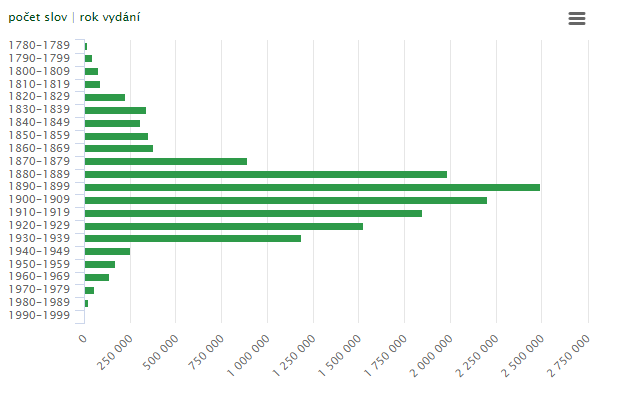

Z GitHubu projektu https://github.com/versotym/corpusCzechVerse jsem stáhl více než tisíc JSON souborů, z nichž každý je sbírkou básní. Daný korpus je lemmatizovaný, foneticky, morfologicky, metricky a stroficky anotovaný, obsahuje tedy hodně informací užitečných pro jiné výzkumy, ale zbytečné v rámci této práce. 

In [ ]:
import os
import json

In [ ]:
files_list = os.listdir('drive/MyDrive/Poems')

Při parcingu JSON souborů jsem nechal pouze tyto informace:



*   Jméno autora
*   Název básně
*   Rok vydání
*   Text básně
*   Bag of words - pouze lemmata autosémantických slov (https://www.czechency.org/slovnik/AUTOS%C3%89MANTIKUM) - substantiv, adjektiv, sloves a adverbií, vyjma slovesa *být*. 

Kromě toho jsem odstranil duplicity, kterých v původním korpusu bylo zhruba 20-30 tisíc.

Data jsem se rozhodl uložit jako seznam jednotek - bloků, ekvivalentních slokám. 

In [ ]:
poem_blocks = [] # vysledny seznam zpracovanych slok
texts = []       # docasny seznam pouze textu pro ucel odstraneni duplicit
for json_file in files_list:
    json_text = json.load(open('drive/MyDrive/Poems/' + json_file))
    for text in json_text:
        for poem in text['body']:
            bag = []
            poem_text = []
            for block in poem:
                poem_text.append(block['text'])
                for word in block['words']:
                    if word['morph'][0] in ['N','A','V','D'] and word['lemma'] != 'být':
                        bag.append(word['lemma'])
            poem_text = '\n'.join(poem_text)
            
            if poem_text not in texts:
                texts.append(poem_text)
                new_block = {'bag':bag, 
                             'text':poem_text,
                             'author_name': text['p_author']['name'], 
                             'poem_name': text['biblio']['p_title'],
                             'date': text['biblio']['year']}
                poem_blocks.append(new_block)

In [ ]:
print(len(poem_blocks))

Seznam můžeme uložit jako JSON soubor. Oproti původnímu korpusu daný soubor beze zbytečných informací je cca 10 krát menší (242Mb).

## Data

Sémantiku každé sloky můžeme vyjádřit jako matici (N-rozměrný NumPy Array) složenou z vektorů jednotlivých slov.

In [ ]:
def bag_to_matrix(bag):
        mx = []
        for word in bag:
            try:
                mx.append(model.wv[word])
            except:
                pass # pokud vokabular modelu neobsahuje dane slovo
        return np.vstack(mx) if len(mx) > 0 else np.array([])

Abychom nemuseli pokaždé vypočítávat 350 tisíc matic za podmínky, že náš korpus je pořád stejný, je rozumné vypočítat je jednou předem a uložit také do souboru.  

In [ ]:
poems_json = json.load(open('drive/MyDrive/Word2Vec/data.json'))

matrices_from_json = []
for block in poems_json:
    matrices_from_json.append(bag_to_matrix(block['bag']))

Teď nastává další problém. Seznam tak rozsáhlého počtu matic je poměrně velký, abychom ho mohli mít v paměti. Prostředí Colab se restartuje, když celkový objem dat přesahuje velikost RAM. Řešení - uložit jako zmapovaný soubor na disku a vyhledávat po jednotlivých chuncích. Pro tento účel jsem použil knihovnu Zarr.

In [ ]:
!pip install zarr
import zarr
import numcodecs

In [ ]:
store = zarr.DBMStore('database.db')
z = zarr.zeros(shape=(352490,), chunks=(1000,), dtype='object', object_codec=numcodecs.Pickle(), store=store, overwrite=True)
z[:] = data # data - kombinace souboru korpusu s pridanymi maticemi pro kazdou sloku
store.close() 

## Vyhledávání 

Princip vyhledávání je založen na vytvoření vektoru (případně matice) odpovídajícího hledanému výrazu a následujícím porovnání se všemi maticemi v databázi.

Míra podobnosti dvou výrazu je součtem součinu jejich matic děleno součtem velikostí obou matic. Násobení dekadickým logaritmem velikosti původní matice ukazuje lepší výsledky.

In [ ]:
def semantic_similarity_fast_log(mx1, mx2):
        if mx1.size > 0 and mx2.size > 0:
            return np.sum(np.matmul(mx1, mx2.T)) * np.log10(mx2.size) / (mx2.size + mx1.size)
        else:
            return 0.0

In [ ]:
def search_in_poems(search, blocks):
    search_list = search.split()
    result = [] # do seznamu vysledku zapisujeme informace o slokach 
                # s jejich mirou semanticke podobnosti vuci hledanemu vyrazu
    for block in blocks:
        result.append({'text': block['text'], 
                    'author_name': block['author_name'], 
                    'poem_name': block['poem_name'], 
                    'date': block['date'], 
                    'score': semantic_similarity_fast_log(bag_to_matrix(search_list), 
                                                            block['matrix'])})
    print_results(result)

In [ ]:
# tato funkce serazuje seznam dle jejich skoru, pak vypisuje 10 nejlepsich

def print_results(result):
    newlist = sorted(result, key=lambda d: d['score'], reverse=True) 
    for index, block in enumerate(newlist):
        if index == 10:
            break
        print(block['author_name'])
        print(block['poem_name'], ',', block['date'], '\n')
        print(block['text'])
        print('\n')
        print('score:', block['score'], '\n')
        print('-'*30)

# Optimizace

Při zpracování databáze matic se setkáváme s poměrně složitou optimizační úlohou. Pro uložení dat používáme buď rychlou, ale omezenou RAM (v tomto případě přicházíme o úplnost dat. max 250k v Colabu), nebo skoro neomezený, ale výrazně pomalejší disk.

Tabulka níže znázorňuje vztah velikosti použité databáze a rychlosti analýzy v sekundách v závislosti na použité metodě (seznam v RAM nebo Zarr soubor).

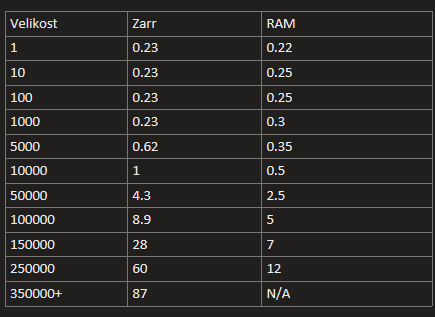

Způsoby, které mě napadly, jak se daná úloha dá optimizovat:


*   Jiná velikost chunků Zarr. Menší počet větších chunku pomůže zrychlit analýzu. Nejde však o výrazné zlepšení.

*   Použití jiného modelu s jinou rozměrností vektorů. Počet dimenzí 100 oproti 400 zmenší potřebný prostor o 4krát.

*   Použití modelu doc2vec místo word2vec.

*   Překódovat matic do jiného úspornějšího formátu.






# Výsledky

Tady uvádím různé zajímavé příklady a kuriozity, které se mi podařilo najít pomocí sémantické analýzy korpusu básní, a zároveň znázorňující princip algoritmu.

Zajímavé je vyhledávat skutečnosti, které se pravděpodobně nevyskytují v korpusu. Například tykající se současnosti, vlastní jména, značky apod.

## Zajímavosti. Skutečnosti ze současnosti

In [ ]:
search_in_poems('internet', db_list)

**Machar, Josef Svatopluk
JISTÝ POKROK , 1935**

Reklamy všeho: osobnosti,

věd, uměn, kšeftů, praktik všech,

pa-cností našich, velikostí

a reklamy pak reklam těch.


**score: 0.5282242806767489** 

---

**Zeyer, Julius
PIA DE’TOLOMEI. , 1892**


jí odpověděl hlasem hromovým,

„je v síti už, a běda, běda jí!“


**score: 0.4586370397115392**

---






In [ ]:
search_in_poems('mobil', db_list)

**Neruda, 
Jan 
Z tábora konservativního , 1951**

Co koupil jsem si každý rok,

též letos sobě koupím,

a byl-li hlup jsem každý rok,

též letos budu hloupým!


**score: 0.34395199326540743** 

---

**Racek, Adolf 
Ten nástroj nekoupím, , 1902**

Ten nástroj nekoupím, 

ten nástroj ukradnu!


**score: 0.36809631066433507**

---

In [ ]:
search_in_poems('pračka', db_list)

**Vinařický, Karel Alois
Zvuky vodní. , 1845**

Při ohni voda se vaří,

Kypí a paří,

V nádobě klochtá.

Pradlena ve vodě šplochtá,

Prádlo máchajíc, vodou cáká,

Z necek mydlina skáká.


**score: 0.24407946760390173**

---

## Zajímavosti. Osobnosti ze současnosti

In [ ]:
search_in_poems('beyoncé', db_list)

**Racek, Adolf
Budeme tančit, , 1902**

Budeme zpívat,

bez smyslu zpívat,

vysoko zpívat,

bez konce zpívat!


**score: 0.6059528486236053**



In [ ]:
search_in_poems('gosling', db_list)

**z Wojkowicz, Jan
DRAMA ŠAŠKOVO. (II.) , 1915** 

Hraju snad roli šaška –

ale jsem Shakespearův šašek:

Jen srdce je blázen –

ale rozum, ale rozum – –


**score: 0.19922014905329014** 

In [ ]:
search_in_poems('putin', db_list)

**Machar, Josef Svatopluk
VÍDEŇSKÝ KONGRES. , 1921** 

I ruský císař? Také ruský císař,


**score: 0.8164775529543226**

---

**Machar, Josef Svatopluk
DVA KOZÁCI. , 1921** 

– Vždyť vidíš, nemá. Car náš se s ním vede,

jak moh by jít car pravoslavný s čertem? –


**score: 0.7035954962675044**

In [ ]:
search_in_poems('babiš', db_list)

**Machar, Josef Svatopluk
VLÁDA , 1935**

Ministrpresident v posteli,

ministr financí utek,

ministr jeden se veselí,

obé že libý je skutek.


**score: 0.6809947190724027** 

---

**Kamarýt, Josef Vlastimil 231. , 1834**

Co sám sobě uděláš,

za to peněz nepodáš.


**score: 0.6420638036565316**

---

**Gellner, František
KRÁDEŽ , 1926**

Věc přišla k soudu. No, jakáž pomoc!

K soudu šel za mě můj táta.

Ten umí lhát! A na výpomoc

vzal ještě advokáta.


**score: 0.5937962364161368**

---

## Závěr

Algoritmus *většinou* funguje docela spolehlivě, můžeme pozorovat, jak rozpoznává sémantické souvislosti a nachází asociace a významové vztahy tam, kde určitě původně nebyly. I když je vyhledávání omezeno na značně časově a  prostorově ohraničenou doménu českých básní.

Můžeme algoritmus využit i přímo pro vyhledání básní na určité téma. Např. *o jaře, nebo dešti, matce, jídle, cestování* atd. 

Poněkud hůře funguje vyhledávání abstraktních myšlenek nebo pocitů, takových jak *smutek, zrada, žárlivost* atd. Předpokládám, že toto je dáno korpusem, na kterém je natrénován model. Články na Wikipedii jsou stylově vzdálenější od básní, nejsou v nich zastoupené mnohé sémantické kontexty, které by umožnili modelu lépe "pochopit" význam slov, zvláště těch abstraktních. 

**Návrhy pro vylepšení programu:**

1.   Natrénovat model na jiném korpusu. Nejlépe obsahujícím texty co nejvíce různých stylů, žánrů atd. Např. vyvážené korpusy řady SYN.
2.   Pro trénování modelu použit výhradně lemmata tak, aby pro všechny tvary jednoho slova existoval pouze jeden sémantický vektor. Daná změna by měla značně zlepšit kvalitu vyhledávání, protože v čím více možných kontextech bude zastoupeno slovo, tím přesněji bude určen jeho význam.
Model natrénovaný na nelemmatizovaném korpusu považuje každý tvar za samostatné slovo s odlišným, ač podobným významem.
3.   Při tvoření BOW (bag of words) použit každé slovo z textu pouze jednou. V básních jsou častá opakování, která výrazně mění "významový profil" celé sloky, silně ovlivňují hodnoty ve výsledné matici významu.
4.   Vyzkoušet jiný typ modelu - doc2vec, který umožňuje vytvořit sémantický vektor přímo z celého dokumentu (textu). Je dost možné, že takový přístup bude rozumnější a dokáže vyřešit i optimizační problémy vyvolané nadprůměrnou velikostí databáze matic. Kromě toho, pravděpodobně bude účinnější při vyhledávání významu jednotlivých textu.



# Zdroje

*   Пирожки в дистрибутивной семантике / Хабр. [online]. Copyright © 2006 [cit. 22.01.2023]. Dostupné z: https://habr.com/ru/post/275913/

*   KČV :: VersoTým . versologie.cz [online]. Copyright © 2023 Petr Plecháč [cit. 22.01.2023]. Dostupné z: https://versologie.cz/v2/web_content/corpus.php?lang=cz

*   Documentation — gensim. Radim Řehůřek: Machine learning consulting [online]. Copyright © Copyright 2009 [cit. 22.01.2023]. Dostupné z: https://radimrehurek.com/gensim/auto_examples/index.html##documentation

*   AUTOSÉMANTIKUM | Nový encyklopedický slovník češtiny. Nový encyklopedický slovník češtiny [online]. Copyright © Masarykova univerzita, Brno 2012 [cit. 22.01.2023]. Dostupné z: https://www.czechency.org/slovnik/AUTOS%C3%89MANTIKUM

*   Tutorial — zarr 2.13.6 documentation. [online]. Copyright © Copyright 2022, Zarr Developers [cit. 22.01.2023]. Dostupné z: https://zarr.readthedocs.io/en/stable/tutorial.html#

*   NumPy Reference — NumPy v1.24 Manual. NumPy [online]. Copyright © Copyright 2008 [cit. 22.01.2023]. Dostupné z: https://numpy.org/doc/stable/reference/index.html


